In [1]:
import numpy as np
import time
import pickle
import utils as Utils
import pandas as pd
import random
from sklearn import svm
import seaborn as sns
import matplotlib.pyplot as plt
# import modules.model as Model
from matplotlib.backends.backend_pdf import PdfPages
import sklearn.metrics as metrics

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,roc_auc_score,classification_report,roc_curve,auc, f1_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import plotly.graph_objects as go
from imblearn.over_sampling import SMOTE 
# import modules.processor as Processor
# import modules.utils as Utils
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from tqdm import tqdm
import processor as Processor

In [2]:
# !pip3 install xgboost

In [3]:
train_trb = pd.read_csv("./data_final/train_trb.csv")
test_trb = pd.read_csv("./data_final/test_trb.csv")

In [4]:
train_trb_case1_rf_20 = pd.read_csv("./data_final/train_trb_case1_rf_20.csv",)
test_trb_case1_cb_60  = pd.read_csv("./data_final/test_trb_case1_cb_60.csv", )
train_trb_case2_rf_20 = pd.read_csv("./data_final/train_trb_case2_rf_20.csv",)
test_trb_case2_cb_60  = pd.read_csv("./data_final/test_trb_case2_cb_60.csv", )
train_trb_case3_rf_20 = pd.read_csv("./data_final/train_trb_case3_rf_20.csv",)
test_trb_case3_cb_60  = pd.read_csv("./data_final/test_trb_case3_cb_60.csv", )

In [5]:
test_paper_case1_exc_epi = pd.read_csv("./data_final/test_paper_case1_exc_epi.csv")

# Case 01

In [6]:
nm = RandomUnderSampler(random_state=42)
X_res_case1, y_res_case1 = nm.fit_resample(train_trb_case1_rf_20[["CDR3b", "epitope"]], train_trb_case1_rf_20[["binder"]])

In [7]:
X_res_case1.shape, y_res_case1.shape

((22240, 2), (22240, 1))

In [8]:
pX_res_case1 = Processor.data_representation_blosum62(X_res_case1)
py_res_case1 = y_res_case1.copy()

pX_test_rf_case1 = Processor.data_representation_blosum62(test_trb_case1_cb_60)
py_test_rf_case1 = test_trb_case1_cb_60[["binder"]]

pX_test_cb_case1 = Processor.data_representation_blosum62(test_trb)
py_test_cb_case1 = test_trb[["binder"]]

In [9]:
pX_test_paper = Processor.data_representation_blosum62(test_paper_case1_exc_epi)
py_test_paper = test_paper_case1_exc_epi[["binder"]]

In [10]:
print(pX_res_case1.shape, py_res_case1.shape)
print(pX_test_rf_case1.shape, py_test_rf_case1.shape)
print(pX_test_cb_case1.shape, py_test_cb_case1.shape)
print(pX_test_paper.shape, py_test_paper.shape)

(22240, 600) (22240, 1)
(781623, 600) (781623, 1)
(279997, 600) (279997, 1)
(5381, 600) (5381, 1)


In [11]:
lst_models = [
#     ('Logistic Regression - [solver: lbfgs]', LogisticRegression(solver='lbfgs')),
#     ('Logistic Regression - [solver: liblinear]', LogisticRegression(solver='liblinear')),
#     ('Logistic Regression - [solver: newton-cg]', LogisticRegression(solver='newton-cg')),
#     ('KNN - [n_neighbors: 2]', KNeighborsClassifier(n_neighbors=2)),
#     ('KNN - [n_neighbors: 3]', KNeighborsClassifier(n_neighbors=3)),
#     ('SVC - [kernel: linear]', SVC(kernel='linear', random_state=42)),
#     ('SVC - [kernel: poly]', SVC(kernel='poly', random_state=42)),
#     ('SVC - [kernel: rbf]', SVC(kernel='rbf', random_state=42)),
#     ('SVC - [kernel: sigmoid]', SVC(kernel='sigmoid', random_state=42)),
#     ('Bernoulli', BernoulliNB()),
    ('Random Forest', RandomForestClassifier(random_state=42, n_jobs=-1)),
#     ('XGBoost', XGBClassifier(eval_metric='mlogloss'))
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
def train(lst_models, X, y, cv):
    res_table = []
    for mdl_name, model in tqdm(lst_models):
        tic = time.time()
        cv_res = cross_validate(model, X, y, cv=cv, return_train_score=True, scoring=['accuracy', 'roc_auc'], n_jobs=-1)
        res_table.append([mdl_name, 
                          cv_res['train_accuracy'].mean(), 
                          cv_res['test_accuracy'].mean(), 
                          np.abs(cv_res['train_accuracy'].mean() - cv_res['test_accuracy'].mean()),
                          cv_res['train_accuracy'].std(),
                          cv_res['test_accuracy'].std(),
                          cv_res['train_roc_auc'].mean(),
                          cv_res['test_roc_auc'].mean(),
                          np.abs(cv_res['train_roc_auc'].mean() - cv_res['test_roc_auc'].mean()),
                          cv_res['train_roc_auc'].std(),
                          cv_res['test_roc_auc'].std(),
                          cv_res['fit_time'].mean()
        ])
        toc = time.time()
        print('\tModel {} has been trained in {:,.2f} seconds'.format(mdl_name, (toc - tic)))
    
    res_table = pd.DataFrame(res_table, columns=['model', 'train_acc', 'test_acc', 'diff_acc',
                                                 'train_acc_std', 'test_acc_std', 'train_roc_auc', 'test_roc_auc',
                                                 'diff_roc_auc', 'train_roc_auc_std', 'test_roc_auc_std', 'fit_time'])
    res_table.sort_values(by=['test_acc', 'test_roc_auc'], ascending=False, inplace=True)

    return res_table.reset_index(drop=True)

In [13]:
original_models = train(lst_models, pX_res_case1, np.ravel(py_res_case1), cv)
original_models

100%|██████████| 1/1 [00:13<00:00, 13.62s/it]

	Model Random Forest has been trained in 13.62 seconds


,model,train_acc,test_acc,diff_acc,train_acc_std,test_acc_std,train_roc_auc,test_roc_auc,diff_roc_auc,train_roc_auc_std,test_roc_auc_std,fit_time
0,Random Forest,0.999989,0.959622,0.040366,0.000022,0.002093,1.0,0.992482,0.007518,0.0,0.001338,0.928527


In [14]:
lst_tunning_models = [
     ('Random Forest', RandomForestClassifier(random_state=42, n_jobs=-1), {
        'bootstrap': [True, False],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'max_features': ["auto", "sqrt", "log2", 5, 10, 15, 20],
        'min_samples_leaf': [1, 2, 4],
        'n_estimators': [200, 400, 600, 800, 1000]})]

def trainTunningModel(lst_models, X, y, cv):
    models_final = []
    for model_name, model, params in tqdm(lst_models):
        tic     = time.time()
        search = GridSearchCV(estimator=model, param_grid=params, cv=cv, scoring='accuracy', n_jobs=-1)
        search.fit(X, y)
        model_tunned = model.set_params(**search.best_params_)
        models_final.append((model_name, model_tunned))
        toc = time.time()
        print('Model {} has been tunned in {:,.2f} seconds'.format(model_name, (toc - tic)))

    return models_final

In [15]:
# lst_tunning_models = trainTunningModel(lst_tunning_models, pX_res_case1, np.ravel(py_res_case1), cv)
# lst_tunning_models

In [16]:
lst_tunning_models = [('Random Forest',
  RandomForestClassifier(bootstrap=False, max_depth=20, max_features='auto',
                         n_estimators=100, n_jobs=-1, random_state=42))]

In [17]:
tunning_models = train(lst_tunning_models, pX_res_case1, np.ravel(py_res_case1), cv)
tunning_models

100%|██████████| 1/1 [00:02<00:00,  2.22s/it]

	Model Random Forest has been trained in 2.22 seconds


,model,train_acc,test_acc,diff_acc,train_acc_std,test_acc_std,train_roc_auc,test_roc_auc,diff_roc_auc,train_roc_auc_std,test_roc_auc_std,fit_time
0,Random Forest,0.987534,0.960971,0.026562,0.0009,0.00264,0.999743,0.993812,0.005931,0.000043,0.001128,0.991317


In [18]:
def evaluation(tunning_models, X_train, y_train, X_test, y_test):
    res = []
    for name, model in tqdm(tunning_models):
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        train_roc_auc = roc_auc_score(y_train, y_train_pred)
        test_roc_auc = roc_auc_score(y_test, y_test_pred)
        res.append([name, train_acc, test_acc, train_roc_auc, test_roc_auc])
        
    res = pd.DataFrame(res, columns=['model', 'train_acc', 'test_acc', 'train_roc_auc', 'test_roc_auc'])
    res.sort_values(by=['test_acc', 'test_roc_auc'], ascending=False, inplace=True)
    
    return res.reset_index(drop=True)

In [19]:
best_models = evaluation(lst_tunning_models, pX_res_case1, np.ravel(py_res_case1), pX_test_rf_case1, py_test_rf_case1)
best_models

100%|██████████| 1/1 [00:03<00:00,  3.22s/it]


,model,train_acc,test_acc,train_roc_auc,test_roc_auc
0,Random Forest,0.985027,0.821518,0.985027,0.544684


In [20]:
def confusionMatrix(y_true, y_pred):
    target_names = ['Non-binder', 'Binder']
    print(classification_report(y_true, y_pred, target_names=target_names))
    cm = pd.DataFrame(confusion_matrix(y_true, y_pred), index=target_names, columns=target_names)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion matrix')
    plt.xlabel('Predicted values')
    plt.ylabel('Actual values')
    plt.show()

In [21]:
def model_run(algo, pX_res, py_res, pX_test, py_test):

    algo.fit(pX_res, np.ravel(py_res))
    y_pred = algo.predict(pX_test)
    y_pred_proba = algo.predict_proba(pX_test)[:,1]
    
    accuracy = accuracy_score(py_test, y_pred).ravel()
    classify_metrics = classification_report(py_test, y_pred)
    f1 = f1_score(py_test, y_pred).ravel()
    
    fpr, tpr, thresholds = roc_curve(py_test, y_pred_proba)
    auc_score = auc(fpr, tpr)
    tn, fp, fn, tp = confusion_matrix(py_test, y_pred).ravel()
    confusionMatrix(py_test, y_pred)
    
    print (algo)
    print ("Accuracy score        : ", accuracy)
    print ("F1 score              : ", f1)
    print ("AUC                   : ", auc_score)
    print ('Sensitivity (TPR)     : ', tp/(tp+fn))
    print ('Specificity (TNR)     : ', tn/(tn+fp))
    print ("classification report :\n", classify_metrics)
    
    return accuracy, classify_metrics, fpr , tpr, auc_score, f1

              precision    recall  f1-score   support

  Non-binder       0.91      0.89      0.90    707865
      Binder       0.16      0.20      0.18     73758

    accuracy                           0.82    781623
   macro avg       0.54      0.54      0.54    781623
weighted avg       0.84      0.82      0.83    781623



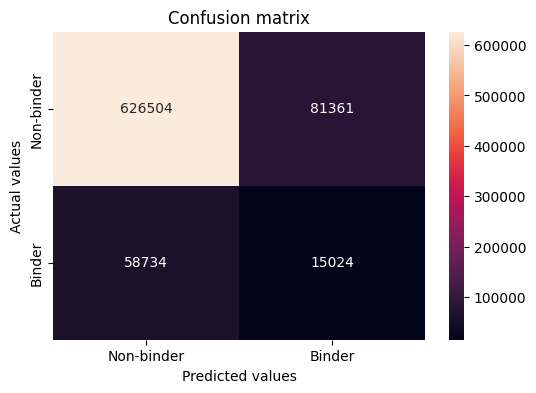

Accuracy score  :  0.8207639744480395
Sensitivity (TPR):  0.20369315870820792
Specificity (TNR):  0.8850614170781151
AUC :  0.5681971422261158


In [22]:
model_rf = lst_tunning_models[0][1]

y_rf_test_proba = model_rf.predict_proba(pX_test_rf_case1)
df_test_rf = pd.DataFrame(data = y_rf_test_proba, columns = ["tmp", "predict_proba"])

df_test_rf = df_test_rf[["predict_proba"]]
df_prob_test_rf = pd.concat([test_trb_case1_cb_60, df_test_rf], axis=1)
df_prob_test_rf['binder_pred'] = np.where(df_prob_test_rf['predict_proba'] >= 0.5, 1, 0)

y_test02 = py_test_rf_case1["binder"].to_numpy()
y_test02_pred = df_prob_test_rf["binder_pred"].to_numpy()

confusionMatrix(y_test02, y_test02_pred)

tn02, fp02, fn02, tp02 = confusion_matrix(y_test02, y_test02_pred).ravel()
accuracy02 = float(accuracy_score(y_test02, y_test02_pred).ravel())
sensitivity02 = tp02/(tp02+fn02)
specificity02 = tn02/(tn02+fp02)
auc02 = metrics.roc_auc_score(y_test02, df_prob_test_rf["predict_proba"])
print ("Accuracy score  : ", accuracy02)
print('Sensitivity (TPR): ', sensitivity02)
print('Specificity (TNR): ', specificity02)
print ("AUC : ", auc02)

              precision    recall  f1-score   support

  Non-binder       0.94      0.84      0.88    263660
      Binder       0.04      0.10      0.05     16337

    accuracy                           0.79    279997
   macro avg       0.49      0.47      0.47    279997
weighted avg       0.88      0.79      0.84    279997



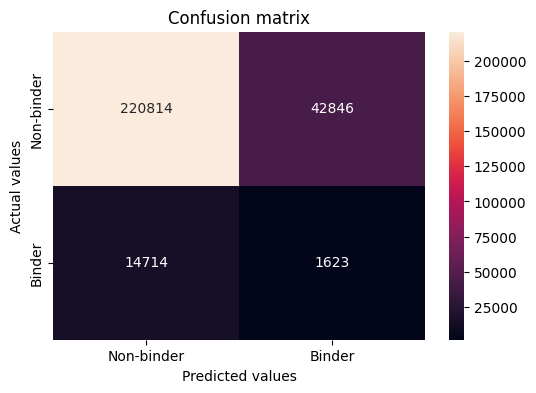

Accuracy score  :  0.794426368853952
Sensitivity (TPR):  0.09934504498990022
Specificity (TNR):  0.8374952590457407
AUC :  0.639980071729451


In [23]:
y_cb_test_proba = model_rf.predict_proba(pX_test_cb_case1)
df_test_cb = pd.DataFrame(data = y_cb_test_proba, columns = ["tmp", "predict_proba"])

df_test_cb = df_test_cb[["predict_proba"]]
df_prob_test_cb = pd.concat([test_trb, df_test_cb], axis=1)
df_prob_test_cb['binder_pred'] = np.where(df_prob_test_cb['predict_proba'] >= 0.5, 1, 0)

y_test02 = py_test_cb_case1["binder"].to_numpy()
y_test02_pred = df_prob_test_cb["binder_pred"].to_numpy()

confusionMatrix(y_test02, y_test02_pred)

tn02, fp02, fn02, tp02 = confusion_matrix(y_test02, y_test02_pred).ravel()
accuracy02 = float(accuracy_score(y_test02, y_test02_pred).ravel())
sensitivity02 = tp02/(tp02+fn02)
specificity02 = tn02/(tn02+fp02)
auc02 = metrics.roc_auc_score(y_test02, df_prob_test_cb["predict_proba"])
print ("Accuracy score  : ", accuracy02)
print('Sensitivity (TPR): ', sensitivity02)
print('Specificity (TNR): ', specificity02)
print ("AUC : ", auc02)

              precision    recall  f1-score   support

  Non-binder       0.99      0.76      0.86      5297
      Binder       0.02      0.37      0.04        84

    accuracy                           0.76      5381
   macro avg       0.51      0.57      0.45      5381
weighted avg       0.97      0.76      0.85      5381



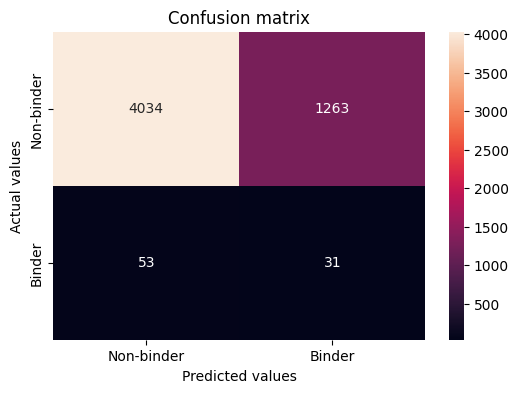

Accuracy score  :  0.7554357926036053
Sensitivity (TPR):  0.36904761904761907
Specificity (TNR):  0.7615631489522371
AUC :  0.5311092532161061


In [24]:
y_test_proba_paper = model_rf.predict_proba(pX_test_paper)
df_test_paper = pd.DataFrame(data = y_test_proba_paper, columns = ["tmp", "predict_proba"])

df_test_paper = df_test_paper[["predict_proba"]]
df_prob_test_paper = pd.concat([test_paper_case1_exc_epi, df_test_paper], axis=1)
df_prob_test_paper['binder_pred'] = np.where(df_prob_test_paper['predict_proba'] >= 0.5, 1, 0)

y_test02 = py_test_paper["binder"].to_numpy()
y_test02_pred = df_prob_test_paper["binder_pred"].to_numpy()

confusionMatrix(y_test02, y_test02_pred)

tn02, fp02, fn02, tp02 = confusion_matrix(y_test02, y_test02_pred).ravel()
accuracy02 = float(accuracy_score(y_test02, y_test02_pred).ravel())
sensitivity02 = tp02/(tp02+fn02)
specificity02 = tn02/(tn02+fp02)
auc02 = metrics.roc_auc_score(y_test02, df_prob_test_paper["predict_proba"])
print ("Accuracy score  : ", accuracy02)
print('Sensitivity (TPR): ', sensitivity02)
print('Specificity (TNR): ', specificity02)
print ("AUC : ", auc02)

## NetTCR

              precision    recall  f1-score   support

  Non-binder       0.92      0.80      0.86    707865
      Binder       0.14      0.30      0.19     73758

    accuracy                           0.76    781623
   macro avg       0.53      0.55      0.52    781623
weighted avg       0.84      0.76      0.79    781623



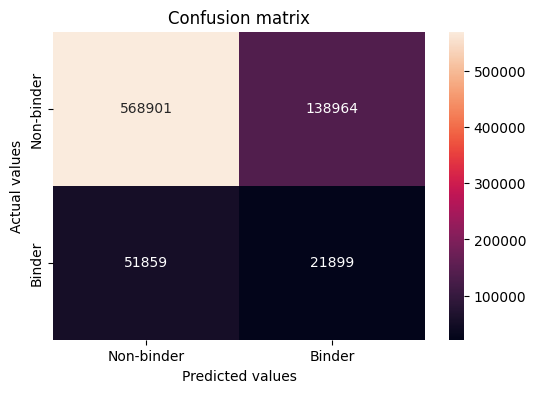

Accuracy score  :  0.7558631207116474
Sensitivity (TPR):  0.29690338675126765
Specificity (TNR):  0.8036857310362852
AUC :  0.6216064070082429


In [25]:
out_ptest_rf_cnn = pd.read_csv("./data_final/output/test_trb_case1_cb_60_output.csv")
out_ptest_rf_cnn['binder_pred'] = np.where(out_ptest_rf_cnn['prediction'] >= 0.5, 1, 0)

y_test = out_ptest_rf_cnn["binder"].to_numpy()
y_test_pred = out_ptest_rf_cnn["binder_pred"].to_numpy()

confusionMatrix(y_test, y_test_pred)

tn, fp, fn, tp= confusion_matrix(y_test, y_test_pred).ravel()
accuracy = float(accuracy_score(y_test, y_test_pred).ravel())
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
auc = metrics.roc_auc_score(y_test, out_ptest_rf_cnn["prediction"])
print ("Accuracy score  : ", accuracy)
print('Sensitivity (TPR): ', sensitivity)
print('Specificity (TNR): ', specificity)
print ("AUC : ", auc)

              precision    recall  f1-score   support

  Non-binder       0.96      0.79      0.87    263660
      Binder       0.13      0.52      0.21     16337

    accuracy                           0.77    279997
   macro avg       0.55      0.65      0.54    279997
weighted avg       0.92      0.77      0.83    279997



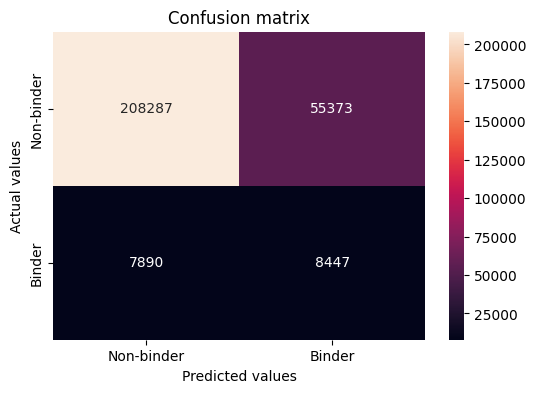

Accuracy score  :  0.7740582934817158
Sensitivity (TPR):  0.5170471934871763
Specificity (TNR):  0.7899833118410073
AUC :  0.7374478673793055


In [26]:
out_ptest_cb = pd.read_csv("./data_final/output/test_trb_case1_output.csv")
out_ptest_cb['binder_pred'] = np.where(out_ptest_cb['prediction'] >= 0.5, 1, 0)

y_test = out_ptest_cb["binder"].to_numpy()
y_test_pred = out_ptest_cb["binder_pred"].to_numpy()

confusionMatrix(y_test, y_test_pred)

tn, fp, fn, tp= confusion_matrix(y_test, y_test_pred).ravel()
accuracy = float(accuracy_score(y_test, y_test_pred).ravel())
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
auc = metrics.roc_auc_score(y_test, out_ptest_cb["prediction"])
print ("Accuracy score  : ", accuracy)
print('Sensitivity (TPR): ', sensitivity)
print('Specificity (TNR): ', specificity)
print ("AUC : ", auc)

              precision    recall  f1-score   support

  Non-binder       0.99      0.56      0.72      5297
      Binder       0.02      0.49      0.03        84

    accuracy                           0.56      5381
   macro avg       0.50      0.52      0.37      5381
weighted avg       0.97      0.56      0.71      5381



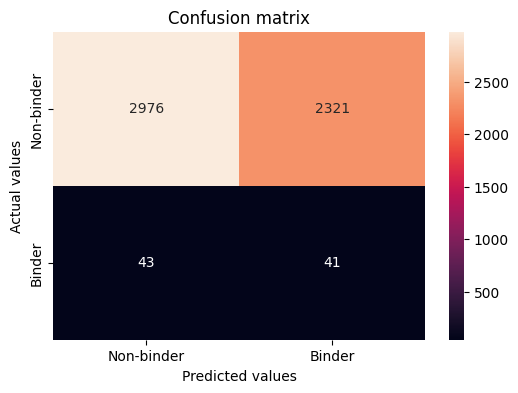

Accuracy score  :  0.5606764541906709
Sensitivity (TPR):  0.4880952380952381
Specificity (TNR):  0.5618274494997169
AUC :  0.5181043627569963


In [27]:
out_ptest_cnn_paper = pd.read_csv("./data_final/output/test_paper_case1_exc_epi_output.csv")
out_ptest_cnn_paper['binder_pred'] = np.where(out_ptest_cnn_paper['prediction'] >= 0.5, 1, 0)

y_test = out_ptest_cnn_paper["binder"].to_numpy()
y_test_pred = out_ptest_cnn_paper["binder_pred"].to_numpy()

confusionMatrix(y_test, y_test_pred)

tn, fp, fn, tp= confusion_matrix(y_test, y_test_pred).ravel()
accuracy = float(accuracy_score(y_test, y_test_pred).ravel())
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
auc = metrics.roc_auc_score(y_test, out_ptest_cnn_paper["prediction"])
print ("Accuracy score  : ", accuracy)
print('Sensitivity (TPR): ', sensitivity)
print('Specificity (TNR): ', specificity)
print ("AUC : ", auc)

## CB

In [28]:
pdata_cb_train = pd.concat([out_ptest_rf_cnn[["prediction"]], df_prob_test_rf[["predict_proba"]]], axis=1)
pdata_cb_train = pdata_cb_train.rename(columns={"predict_proba":"rf_proba", "prediction":"cnn_proba"})

pdata_cb_test = pd.concat([out_ptest_cb[["prediction"]], df_prob_test_cb[["predict_proba"]]], axis=1)
pdata_cb_test = pdata_cb_test.rename(columns={"predict_proba":"rf_proba", "prediction":"cnn_proba"})

pdata_test_paper = pd.concat([out_ptest_cnn_paper[["prediction"]], df_prob_test_paper[["predict_proba"]]], axis=1)
pdata_test_paper = pdata_test_paper.rename(columns={"predict_proba":"rf_proba", "prediction":"cnn_proba"})

In [29]:
X_data = pdata_cb_train.copy()
y_data = out_ptest_rf_cnn[["binder"]]

X_data_test = pdata_cb_test.copy()
y_data_test = out_ptest_cb[["binder"]]

X_data_test_paper = pdata_test_paper.copy()
y_data_test_paper = out_ptest_cnn_paper[["binder"]]

In [30]:
# parameters = {'depth'         : [4,5,6,7,8,9, 10],
#               'learning_rate' : [0.01,0.02,0.03,0.04],
#               'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]}

# CBC = CatBoostClassifier()
# Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 5, n_jobs=-1)
# Grid_CBC.fit(X_data, y_data)

# print(" Results from Grid Search " )
# print("\n The best estimator across ALL searched params:\n", Grid_CBC.best_estimator_)
# print("\n The best score across ALL searched params:\n", Grid_CBC.best_score_)
# print("\n The best parameters across ALL searched params:\n", Grid_CBC.best_params_) 

In [31]:
# model_base = CatBoostClassifier(iterations=1000, learning_rate=1, depth=2)
# model_base.fit(X_data, y_data, verbose=False)

In [32]:
model_tuning = CatBoostClassifier(depth=7, iterations=100, learning_rate=0.04)
model_tuning.fit(X_data, y_data, verbose=False)

In [33]:
y_test_cb = model_tuning.predict_proba(X_data_test)
df_cb = pd.DataFrame(data = y_test_cb, columns = ["tmp", "predict_proba"])
df_cb = df_cb[["predict_proba"]]

df_cb_prob = pd.concat([out_ptest_cb[["CDR3b", "epitope", "binder"]], df_cb], axis=1)
df_cb_prob['binder_pred'] = np.where(df_cb_prob['predict_proba'] >= 0.5, 1, 0)
df_cb_prob

,CDR3b,epitope,binder,predict_proba,binder_pred
0,ASSKRSTDTQY,LVTCLGLSY,0,0.073472,0
1,SARDLETSGGLETQY,LSETFQLLI,0,0.053061,0
2,ASSPPNSYEQY,LLLAHIIAL,0,0.065851,0
3,ASSPTGQGAHGYT,HVYVGNISK,0,0.065687,0
4,ASSGGGLPLSSGNTIY,HSALLALRY,0,0.036594,0
...,...,...,...,...,...
279992,ASYNFGQYGYT,RAFSPEVIPMF,1,0.112485,0
279993,ASSLRDGYTGEL,HISINLPKRI,1,0.758661,1
279994,ASSLRDGYTGEL,WIHWNIPKRI,1,0.071328,0
279995,ASSPSASVNNEQF,YSEHPTFTSQY,1,0.088977,0


              precision    recall  f1-score   support

  Non-binder       0.94      0.99      0.97    263660
      Binder       0.05      0.01      0.01     16337

    accuracy                           0.94    279997
   macro avg       0.50      0.50      0.49    279997
weighted avg       0.89      0.94      0.91    279997



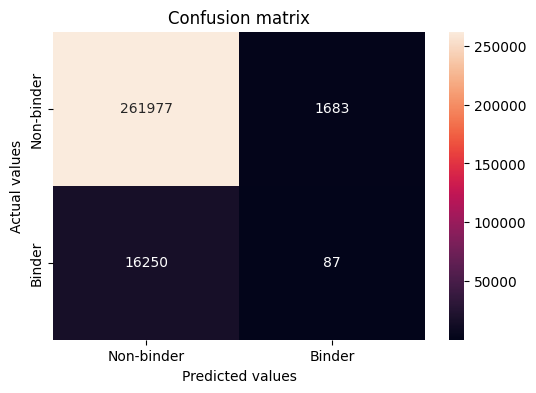

Accuracy score  :  0.9359528852094844
Sensitivity (TPR):  0.005325335128848626
Specificity (TNR):  0.9936167791853144
AUC :  0.5313090235020905


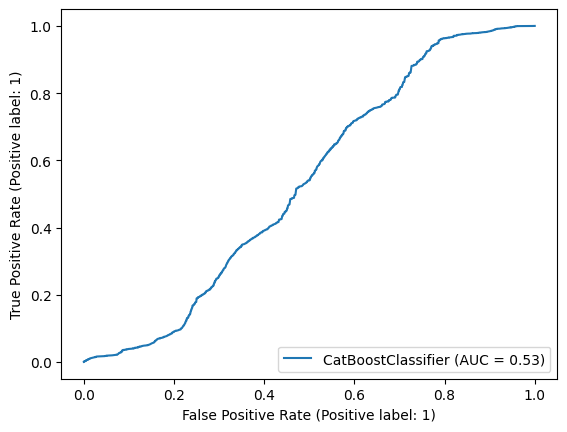

In [39]:
y_test02 = df_cb_prob["binder"].to_numpy()
y_test02_pred = df_cb_prob["binder_pred"].to_numpy()

confusionMatrix(y_test02, y_test02_pred)

tn02, fp02, fn02, tp02 = confusion_matrix(y_test02, y_test02_pred).ravel()
accuracy02 = float(accuracy_score(y_test02, y_test02_pred).ravel())
sensitivity02 = tp02/(tp02+fn02)
specificity02 = tn02/(tn02+fp02)
auc02 = metrics.roc_auc_score(y_test02, df_cb_prob["predict_proba"])
print ("Accuracy score  : ", accuracy02)
print('Sensitivity (TPR): ', sensitivity02)
print('Specificity (TNR): ', specificity02)
print ("AUC : ", auc02)

rocAuc(model_tuning, X_data_test, y_test02)

In [35]:
y_test_cb = model_tuning.predict_proba(X_data_test_paper)
df_cb = pd.DataFrame(data = y_test_cb, columns = ["tmp", "predict_proba"])
df_cb = df_cb[["predict_proba"]]

df_prob_paper = pd.concat([out_ptest_cnn_paper[["CDR3b", "epitope", "binder"]], df_cb], axis=1)
df_prob_paper['binder_pred'] = np.where(df_prob_paper['predict_proba'] >= 0.5, 1, 0)
df_prob_paper

,CDR3b,epitope,binder,predict_proba,binder_pred
0,ASRPGQVVYGYT,LLAIKVPNV,0,0.072311,0
1,ASRPGQVVYGYT,LIIPFIHLI,0,0.266659,0
2,ASRPGQVVYGYT,VLFHRAFLV,0,0.139249,0
3,ASRPGQVVYGYT,FLIYLDVSV,0,0.078298,0
4,ASRPGQVVYGYT,KMVAVFYNT,0,0.423259,0
...,...,...,...,...,...
5376,ASGGTGEYEQY,FMIGYTSAL,1,0.743884,1
5377,ASSGSSVETQY,LIIPFIHLI,1,0.298987,0
5378,ASSGGGGRGYNEQF,LIIPFIHLI,1,0.284984,0
5379,ASSEGLGWEQF,FLIYLDVSV,1,0.079092,0


              precision    recall  f1-score   support

  Non-binder       0.98      0.95      0.97      5297
      Binder       0.02      0.06      0.03        84

    accuracy                           0.93      5381
   macro avg       0.50      0.50      0.50      5381
weighted avg       0.97      0.93      0.95      5381



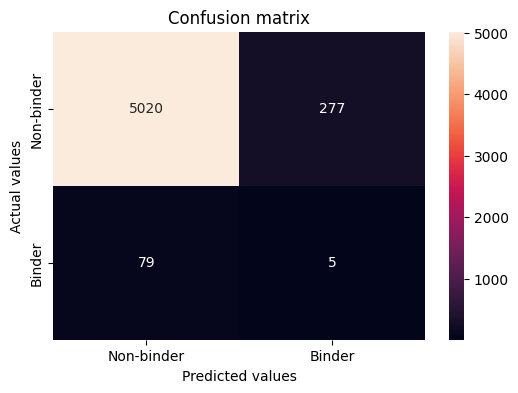

Accuracy score  :  0.9338412934398811
Sensitivity (TPR):  0.05952380952380952
Specificity (TNR):  0.9477062488200868
AUC :  0.4968423276427807


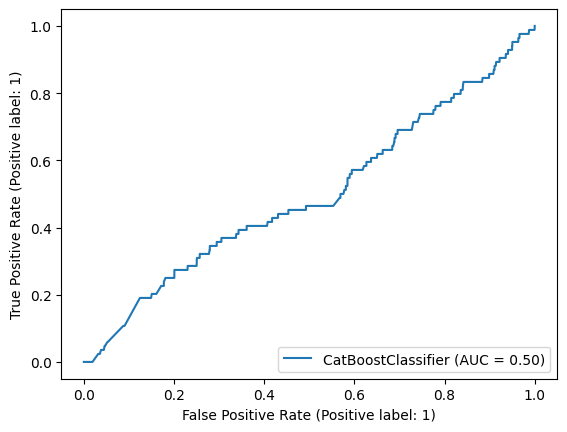

In [38]:
y_test02 = df_prob_paper["binder"].to_numpy()
y_test02_pred = df_prob_paper["binder_pred"].to_numpy()

confusionMatrix(y_test02, y_test02_pred)

tn02, fp02, fn02, tp02 = confusion_matrix(y_test02, y_test02_pred).ravel()
accuracy02 = float(accuracy_score(y_test02, y_test02_pred).ravel())
sensitivity02 = tp02/(tp02+fn02)
specificity02 = tn02/(tn02+fp02)
auc02 = metrics.roc_auc_score(y_test02, df_prob_paper["predict_proba"])
print ("Accuracy score  : ", accuracy02)
print('Sensitivity (TPR): ', sensitivity02)
print('Specificity (TNR): ', specificity02)
print ("AUC : ", auc02)

rocAuc(model_tuning, X_data_test_paper, y_test02)

In [37]:
def rocAuc(model, X, y_true):
    plot_roc_curve(model, X, y_true)
    plt.show()